### EDA

In [1]:
library(ggplot2)
library(ggExtra)
library(tidyverse)
library(lubridate)
library(gridExtra)
library(pROC)
library(ROCR)
library(ROCit)
library(caret)
library(boot)
library(gbm)
# library("cvAUC")

library(MLmetrics)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  3.0.4     v dplyr   1.0.2
v tidyr   1.1.2     v stringr 1.4.0
v readr   1.4.0     v forcats 0.5.0
v purrr   0.3.4     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()


Attaching package: 'lubridate'


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var


Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift



Attaching package: 'boot'


The following object is masked from 'package:lattice':

    melanoma


The following object 

In [120]:
# directories
datadir = "../../DataTD"
cohortdir = "../../OutputTD/1_cohort"
featuredir = "../../OutputTD/2_features"
modeldir4 = "../../OutputTD/3_models/1_4_cohort"
# modeldir4preadmit = "../../OutputTD/3_models/1_4_cohort_24hrpreadmit"
tabledir = "../../OutputTD/4_tables"
resultdir = "../../OutputTD/5_results_analysis"

options(repr.matrix.max.rows=200, repr.matrix.max.cols=30)

In [39]:
cohort <- read.csv(file.path(cohortdir, "1_4_cohort.csv")) %>% mutate(admit_time = ymd_hms(admit_time))
nrow(cohort)

demo <- read.csv(file.path(featuredir, "2_1_coh2_demo.csv"))  %>% mutate(admit_time = ymd_hms(admit_time)) %>% 
            select(anon_id, pat_enc_csn_id_coded, race)
nrow(demo)

esi <- read.csv(file.path(featuredir, "2_5_coh3_imputedHWESI.csv"))  %>% mutate(admit_time = ymd_hms(admit_time)) %>%
            select(anon_id, pat_enc_csn_id_coded, ESI_i) %>% rename(ESI = ESI_i)
nrow(esi)
# adm_year = year(admit_time)

[1] 43980

[1] 45794

[1] 44258

In [40]:
head(cohort,1)
head(demo,1)
head(esi)

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max
,<chr>,<dbl>,<int>,<dttm>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<int>,<int>,<int>,<int>
1,JCd97296,1.31176e+11,18290644,2016-02-06 22:31:00,0,0,NA,0,0,0,0,0,1325,0,0,0,0


,anon_id,pat_enc_csn_id_coded,race
,<chr>,<dbl>,<chr>
1,JC29f8ad2,131274729058,White


,anon_id,pat_enc_csn_id_coded,ESI
,<chr>,<dbl>,<int>
1,JC29f8ad2,131274729058,3
2,JC29f8ad3,131278291027,3
3,JC29f8b9c,131266787806,2
4,JC29f8beb,131264387263,3
5,JC29f8beb,131279241689,3
6,JC29f8bef,131280937356,3


In [44]:
coh_demo <- left_join(cohort, demo) %>% left_join(esi) %>% mutate(race=factor(race))
nrow(coh_demo)
summary(coh_demo)

Joining, by = c("anon_id", "pat_enc_csn_id_coded")

Joining, by = c("anon_id", "pat_enc_csn_id_coded")



[1] 43980

   anon_id          pat_enc_csn_id_coded inpatient_data_id_coded
 Length:43980       Min.   :1.311e+11    Min.   :13616753       
 Class :character   1st Qu.:1.312e+11    1st Qu.:19861137       
 Mode  :character   Median :1.312e+11    Median :27876162       
                    Mean   :1.312e+11    Mean   :28124485       
                    3rd Qu.:1.313e+11    3rd Qu.:34360245       
                    Max.   :1.313e+11    Max.   :48026130       
                                                                
   admit_time                   label_max24     label_24hr_recent
 Min.   :2015-01-01 08:24:00   Min.   :0.0000   Min.   :0.0000   
 1st Qu.:2016-05-21 21:18:15   1st Qu.:0.0000   1st Qu.:0.0000   
 Median :2017-12-29 20:46:30   Median :0.0000   Median :0.0000   
 Mean   :2017-10-11 23:21:00   Mean   :0.1353   Mean   :0.0945   
 3rd Qu.:2019-02-17 03:08:45   3rd Qu.:0.0000   3rd Qu.:0.0000   
 Max.   :2020-03-31 07:00:00   Max.   :1.0000   Max.   :1.0000   
                  

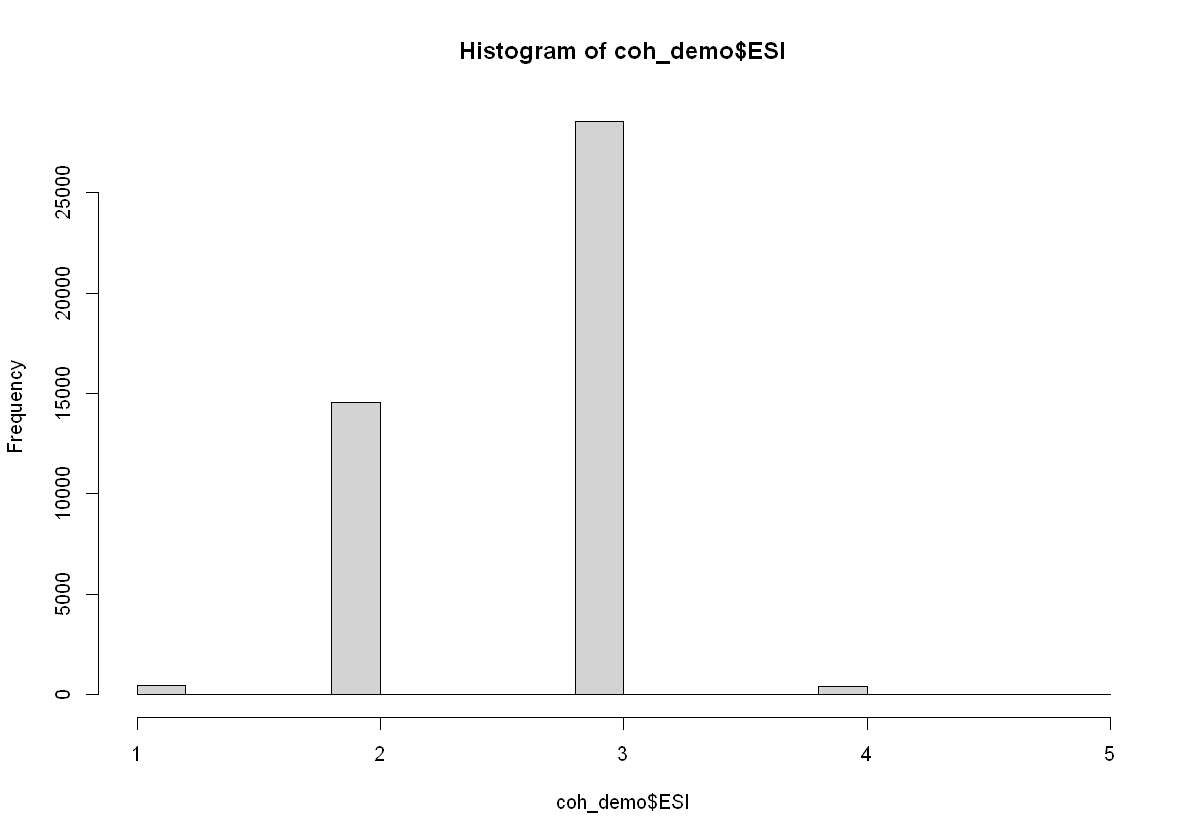

In [52]:
hist(coh_demo$ESI)

In [64]:
race_esi <- coh_demo %>% group_by(race, ESI) %>% summarise(n = n()) %>% 
                group_by(race) %>% mutate(ntotal = sum(n), group_percentage = round(100*n/ntotal, 2))
race_esi

`summarise()` regrouping output by 'race' (override with `.groups` argument)



race,ESI,n,ntotal,group_percentage
<fct>,<int>,<int>,<int>,<dbl>
Asian,1,69,6655,1.04
Asian,2,2307,6655,34.67
Asian,3,4224,6655,63.47
Asian,4,53,6655,0.80
Asian,5,2,6655,0.03
Black,1,43,3104,1.39
Black,2,1084,3104,34.92
Black,3,1938,3104,62.44
Black,4,36,3104,1.16


In [95]:
color_table <- tibble(
  race = c("Asian", "Black", "Native American", "Other", "Pacific Islander", "Unknown", "White"),
  color = c("tan", "grey30", "salmon4", "magenta3", "tan3", "limegreen", "moccasin")
  )
color_table5 <- tibble(
  race = c("Asian", "Black", "Other", "White"),
  color = c("tan", "grey30", "magenta3", "moccasin")
  )

race_esi1 <- race_esi %>% filter(ESI==1)
race_esi23 <- race_esi %>% filter(ESI==2 | ESI==3)
race_esi4 <- race_esi %>% filter(ESI==4)
race_esi5 <- race_esi %>% filter(ESI==5)

race_esi5

race,ESI,n,ntotal,group_percentage
<fct>,<int>,<int>,<int>,<dbl>
Asian,5,2,6655,0.03
Black,5,3,3104,0.10
Other,5,4,10170,0.04
White,5,7,22580,0.03


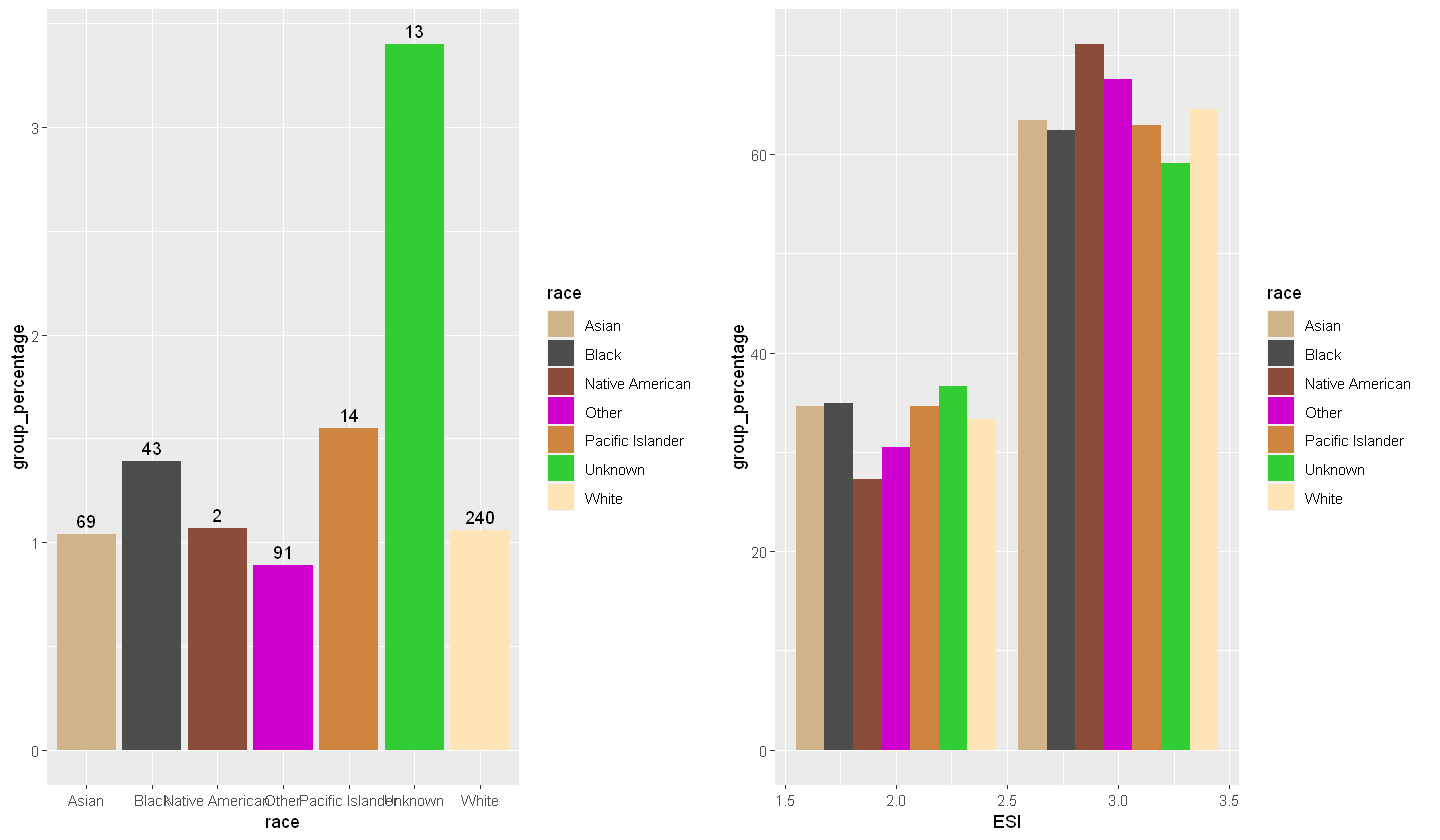

In [123]:
options(repr.plot.width=12, repr.plot.height=7)

p1 <- ggplot(race_esi1, aes(fill=race, y=group_percentage, x=race)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = color_table$color) +
    geom_text(aes(label=n), position=position_dodge(width=1), vjust=-0.5)

p23 <- ggplot(race_esi23, aes(fill=race, y=group_percentage, x=ESI)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = color_table$color) #+
#     geom_text(aes(label=n), position=position_dodge(width=1), vjust=0, angle=90)

grid.arrange(p1, p23, ncol=2)
ggsave(file.path(resultdir,"Fig_ESI123.png"), width = 10, height = 7, dpi = 1200) 

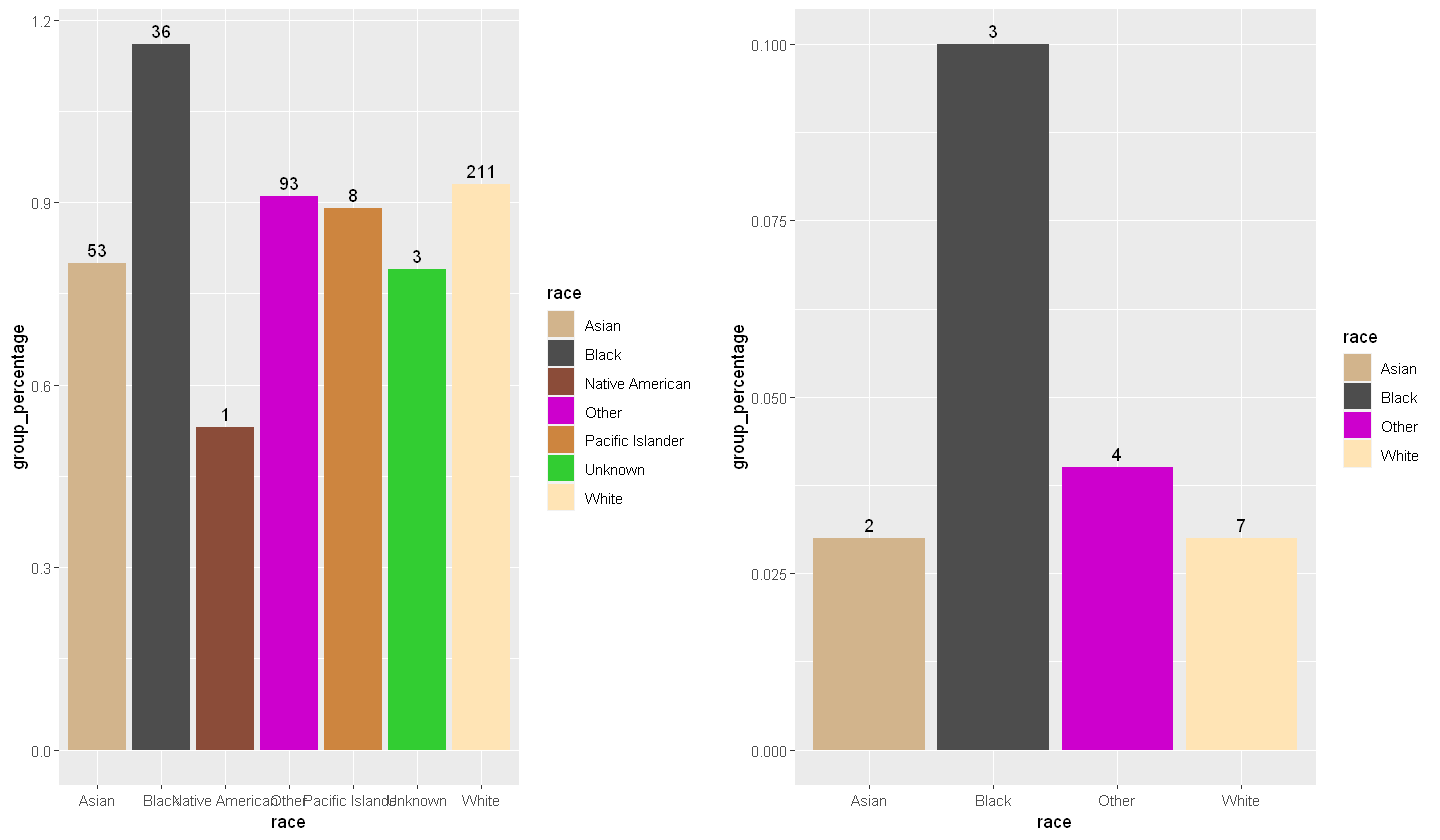

In [124]:
p4 <- ggplot(race_esi4, aes(fill=race, y=group_percentage, x=race)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = color_table$color) +
    geom_text(aes(label=n), position=position_dodge(width=1), vjust=-0.5)

p5 <- ggplot(race_esi5, aes(fill=race, y=group_percentage, x=race)) + 
    geom_bar(position="dodge", stat="identity") + scale_fill_manual(values = color_table5$color) +
    geom_text(aes(label=n), position=position_dodge(width=1), vjust=-0.5)

grid.arrange(p4, p5, ncol=2)
# plotlist <- list(p4, p5)
# plot_grid(plotlist=plotlist)
ggsave(file.path(resultdir,"Fig_ESI45.png"), width = 10, height = 7, dpi = 1200) 

### density plot of predicted probabilities


In [134]:
coh_test <- read.csv(file.path(modeldir4, "1_4_cohort_test_results.csv")) %>% 
                select(pat_enc_csn_id_coded, death_24hr_max_label, death_24hr_recent_label, pred_death_24hr_max, pred_death_24hr_recent)
nrow(coh_test)

# preds_max <- coh_test %>% select(outcome = death_24hr_max_label, prediction = pred_death_24hr_max)
# preds_24hr <- coh_test %>% select(outcome = death_24hr_recent_label, prediction = pred_death_24hr_recent)

[1] 12418

In [135]:
### Plot function, using data0
plotfxn <- function(X, Xlab, Fill, data){
#     p0 <- data %>% ggplot(aes(x=X)) + geom_density() + facet_wrap(~race_recoded) # unable to use Fill here
    p1 <- data %>% ggplot(aes(x=X, fill=Fill)) +
        geom_density(alpha=0.3, position = 'identity') + # color="#e9ecef", 
        labs(fill="") + xlab(Xlab) 

    p2 <- p1 + theme(axis.text=element_text(size=14),
             axis.title=element_text(size=16), legend.key.size = unit(1, "cm"))#, face="bold"
#     return(list(p0, p2))
    return(p2)
}

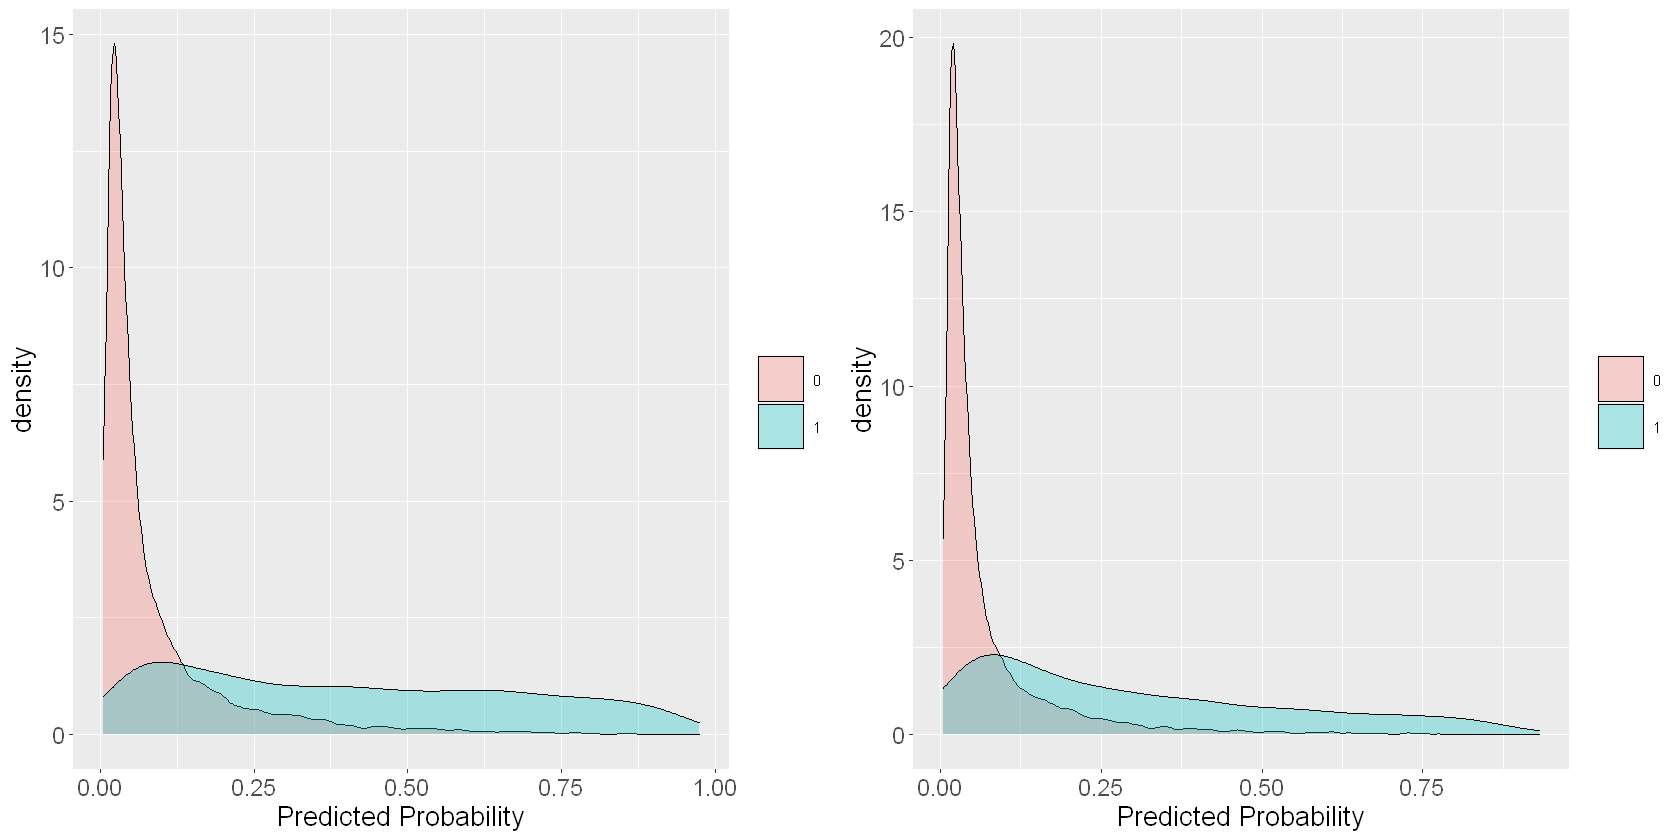

In [142]:
options(repr.plot.width=14, repr.plot.height=7)

pmax <- plotfxn(X=coh_test$pred_death_24hr_max, Xlab="Predicted Probability", Fill=factor(coh_test$death_24hr_max_label), coh_test)
p24 <- plotfxn(X=coh_test$pred_death_24hr_recent, Xlab="Predicted Probability", Fill=factor(coh_test$death_24hr_recent_label), coh_test)

grid.arrange(pmax, p24, ncol=2)
ggsave(file.path(resultdir,"Fig_pred_dens.png"), width = 14, height = 7, dpi = 1200) 